In [126]:
# Allsky chart code based on https://github.com/skyfielders/python-skyfield/discussions/636

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection, PolyCollection

from skyfield.api import Star, load, wgs84, N, S, W, E
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN
from skyfield.data import hipparcos, mpc, stellarium
import dsos
from skyfield.projections import build_stereographic_projection
from datetime import datetime
from pytz import timezone

In [110]:
SEA = timezone('US/Pacific')
ts = load.timescale()
t = ts.from_datetime(SEA.localize(datetime(2023,9,19,6,0,0)))
t_comet = ts.utc(2023, 9, range(1, 15))
# 180 = South, 0 = North
degrees = 0.0

In [111]:
seattle = wgs84.latlon(47.61352679507131, -122.30535433025425, elevation_m=100).at(t)
position = seattle.from_altaz(alt_degrees=90, az_degrees=degrees)

In [112]:
# An ephemeris from JPL provides Sun and Earth positions.

eph = load('de421.bsp')
sun = eph['sun']
earth = eph['earth']

In [113]:
# The Minor Planet Center data file provides the comet orbit.
with load.open(mpc.COMET_URL) as f:
    comets = mpc.load_comets_dataframe(f)
    
comets = (comets.sort_values('reference')
         .groupby('designation', as_index=False).last()
         .set_index('designation', drop=False))

row = comets.loc['C/2023 P1 (Nishimura)']
comet = sun + mpc.comet_orbit(row, ts, GM_SUN)

In [114]:
# The Hipparcos mission provides our star catalog.
with load.open(hipparcos.URL) as f:
    stars = hipparcos.load_dataframe(f)

In [115]:
# The constellation outlines come from Stellarium. We make a list
# of the stars at which each edge starts, and the star at which each edge
# ends

with load.open('constellationship.fab') as f:
    constellations = stellarium.parse_constellations(f)
    
edges = [edge for name, edges in constellations for edge in edges]
edges_star1 = [star1 for star1, star2 in edges]
edges_star2 = [star2 for star1, star2 in edges]

In [116]:
# Center the chart on the zenith
projection = build_stereographic_projection(position)
field_of_view_degrees = 180.0
limiting_magnitude = 6.0
#dso_limit_magnitude = 8.0

In [117]:
# Now that we have constructed our projection, compute the x and y
# coordinates that each star and the comet will have on the plot

star_positions = earth.at(t).observe(Star.from_dataframe(stars))
stars['x'], stars['y'] = projection(star_positions)

comet_x, comet_y = projection(earth.at(t_comet).observe(comet))

In [118]:
# Create a True/False mask marking the stars bright enough to be
# included in our plot. And go ahead and compute how large their
# markers will be on the plot

bright_stars = (stars.magnitude <= limiting_magnitude)
magnitude = stars['magnitude'][bright_stars]
marker_size = (0.5 + limiting_magnitude - magnitude) ** 2.0

In [119]:
# The constellation lines will each begin at the x, y of one star and end
# at the x, y of another. We have to "rollaxis" the resulting coordinate
# array into the shape that matplotlib expects.

In [120]:
xy1 = stars[['x', 'y']].loc[edges_star1].values
xy2 = stars[['x', 'y']].loc[edges_star2].values
lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)

Text(0.5, 1.0, 'Comet C/2023 P1 (Nishimura) 2023 September 01 through 2023 September 14 at 06:00')

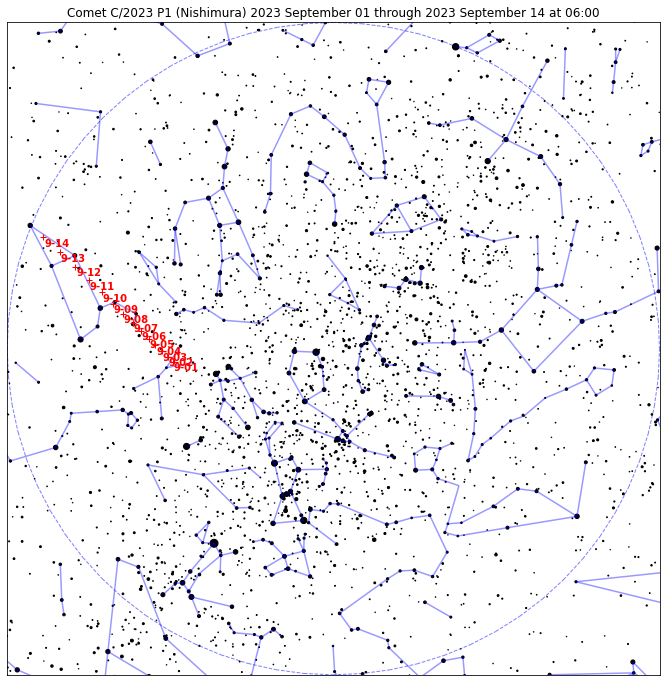

In [125]:
# Time to build the figure!

fig, ax = plt.subplots(figsize=[12, 12], facecolor='white')

# Draw horizon as a dashed line
# 24 points horizon

horizon = []
h0 = projection(seattle.from_altaz(alt_degrees=0, az_degrees=0.0))
for i in range(1, 73):
    delta = 5.0
    current = i*delta
    h1 = projection(seattle.from_altaz(alt_degrees=0, az_degrees=current))
    horizon.append([h0, h1])
    h0 = h1
    
ax.add_collection(LineCollection(horizon, colors='#00f2', linewidths=1, linestyle='dashed',
                                 zorder=-1, alpha=0.5))

# Draw the constellation lines

ax.add_collection(LineCollection(lines_xy, colors=(0, 0, 1, .4)))

# Draw the stars

ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars],
           s=marker_size, color='k', zorder=-1)

# Draw the comet positions

comet_color='#f00'
offset = 0.002

ax.plot(comet_x, comet_y, '+', c=comet_color, zorder=3)

for xi, yi, tstr in zip(comet_x, comet_y, t_comet.utc_strftime('%m-%d')):
    tstr = tstr.lstrip('0')
    text = ax.text(xi + offset, yi - offset, tstr, color=comet_color,
                   ha= 'left', va='top', fontsize=10, weight='bold')

# Finally, title the plot and set some final parameters

angle = np.pi - field_of_view_degrees / 360.0 * np.pi
limit = np.sin(angle / (1.0 - np.cos(angle)))

ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_aspect(1.0)
ax.set_title('Comet C/2023 P1 (Nishimura) {} through {} at {}'.format(
    t_comet[0].utc_strftime('%Y %B %d'),
    t_comet[-1].utc_strftime('%Y %B %d'),
    t.astimezone(SEA).strftime("%H:%M")
))

